In [1]:
import os
os.chdir('../../..')

In [2]:
import convokit
from convokit import TextParser, TensorDecomposer, Corpus, download

In [3]:
corpus = Corpus(filename=download("reddit-coarse-discourse-corpus"))

Dataset already exists at /Users/calebchiam/.convokit/downloads/reddit-coarse-discourse-corpus


In [4]:
corpus.print_summary_stats()

Number of Speakers: 63573
Number of Utterances: 115827
Number of Conversations: 9483


In [5]:
full_convos = {c.id for c in corpus.iter_conversations() if c.check_integrity(verbose=False)}

In [6]:
corpus.filter_conversations_by(lambda convo: convo.id in full_convos)

In [7]:
corpus.print_summary_stats()

Number of Speakers: 62416
Number of Utterances: 113364
Number of Conversations: 9357


In [8]:
for utt in corpus.iter_utterances():
    utt.timestamp = 0

In [9]:
import random

In [10]:
longest_path_ids = []
for convo in corpus.iter_conversations():
    longest_path = random.choice(convo.get_longest_paths())
    convo.meta['longest_path'] = len(longest_path)
    longest_path_ids.extend([utt.id for utt in longest_path])

In [11]:
longest_path_ids = set(longest_path_ids)

In [12]:
corpus = corpus.filter_utterances_by(lambda utt: utt.id in longest_path_ids)

In [13]:
convo_df = corpus.get_conversations_dataframe()

In [14]:
import seaborn as sns

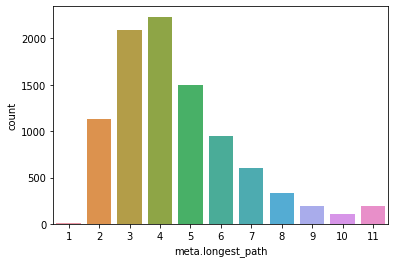

In [15]:
sns.countplot(convo_df['meta.longest_path'])

In [16]:
annotation_types = set()
for utt in corpus.iter_utterances():
    for t in utt.meta['annotation-types']:
        annotation_types.add(t)

In [17]:
annotation_types = sorted(list(annotation_types))
annotation_types

['agreement',
 'announcement',
 'answer',
 'appreciation',
 'disagreement',
 'elaboration',
 'humor',
 'negativereaction',
 'other',
 'question']

In [28]:
for utt in corpus.iter_utterances():
    utt.meta['annot-dict'] = {k: 0 for k in annotation_types}
    for t in annotation_types:
        utt.meta[t] = 0
    for t in utt.meta['annotation-types']:
        utt.meta['annot-dict'][t] = 1
        utt.meta[t] = 1

In [29]:
LENGTH = 8
min_length = lambda utt: utt.meta['valid']

In [30]:
for convo in corpus.iter_conversations():
    utts = convo.get_chronological_utterance_list()
    for utt_idx in range(len(utts) - LENGTH):
        subset = utts[utt_idx: utt_idx + LENGTH]
        start_utt = utts[utt_idx]
        for idx, utt in enumerate(subset):
            start_utt.meta['annot-dict-{}'.format(idx+1)] = utt.meta['annot-dict']
        start_utt.meta['valid'] = True

In [31]:
for utt in corpus.iter_utterances():
    if 'valid' not in utt.meta:
        utt.meta['valid'] = False

In [32]:
td = TensorDecomposer(feature_set=['annot-dict-{}'.format(idx) for idx in range(1, 8+1)], 
                      obj_type="utterance", tensor_func='tensortools-ncp-bcd', rank=20)

In [33]:
td.fit(corpus, selector=min_length)

Constructing tensor...Done.
Decomposing tensor...NCP_BCD: iteration 1, objective 0.8461677096962843, improvement inf.
NCP_BCD: iteration 2, objective 0.8259405829339882, improvement 0.0202271267622961.
NCP_BCD: iteration 3, objective 0.8048959726700196, improvement 0.021044610263968644.
NCP_BCD: iteration 4, objective 0.779614628487521, improvement 0.0252813441824985.
NCP_BCD: iteration 5, objective 0.7585006160373859, improvement 0.02111401245013511.
NCP_BCD: iteration 6, objective 0.7406824534584984, improvement 0.017818162578887575.
NCP_BCD: iteration 7, objective 0.7239285020163754, improvement 0.016753951442122994.
NCP_BCD: iteration 8, objective 0.7077985105417205, improvement 0.01612999147465488.
NCP_BCD: iteration 9, objective 0.6935149035583654, improvement 0.014283606983355068.
NCP_BCD: iteration 10, objective 0.6814295979522556, improvement 0.012085305606109875.
NCP_BCD: iteration 11, objective 0.6709294240943295, improvement 0.01050017385792601.
NCP_BCD: iteration 12, objec

Directory already exists. Exiting summarize()


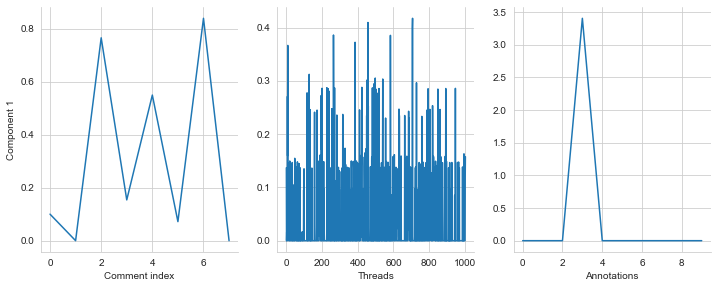

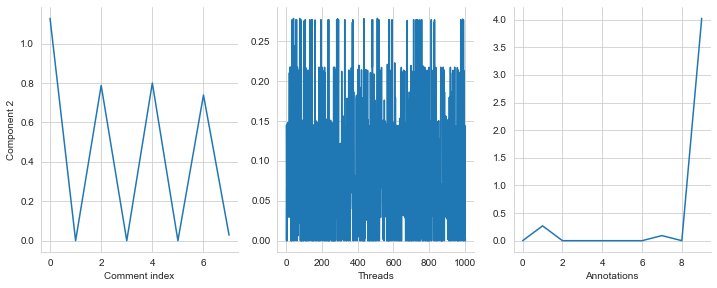

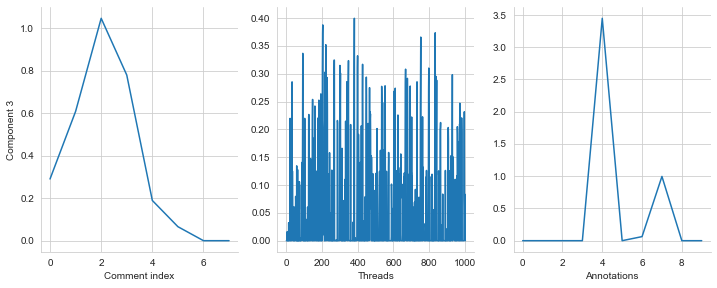

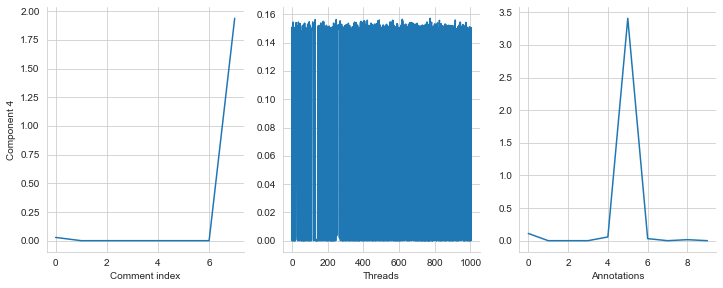

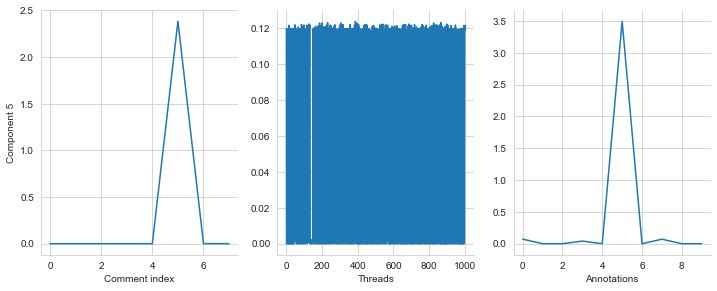

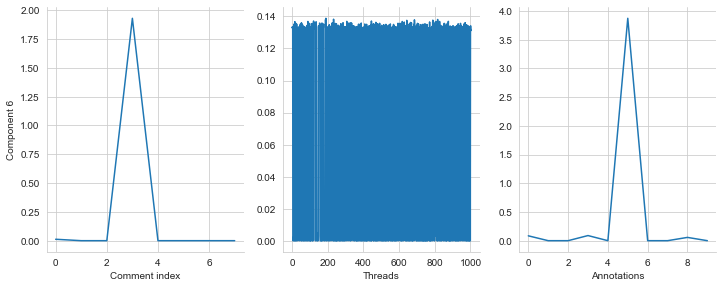

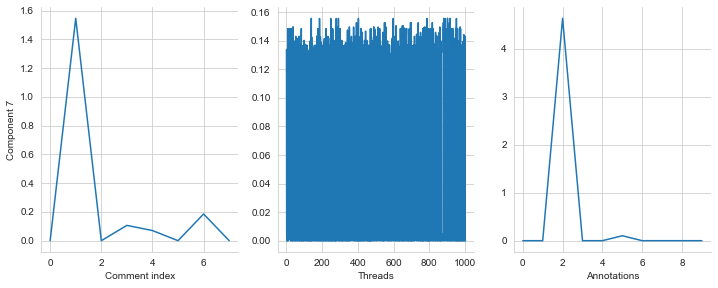

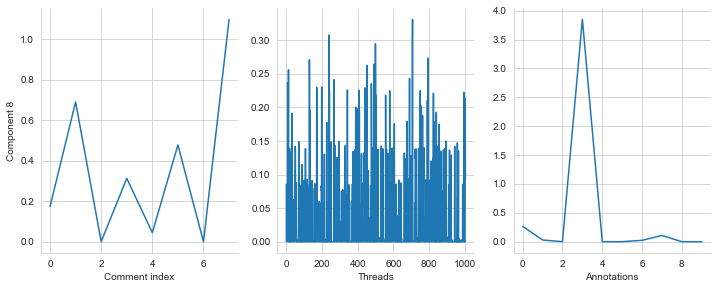

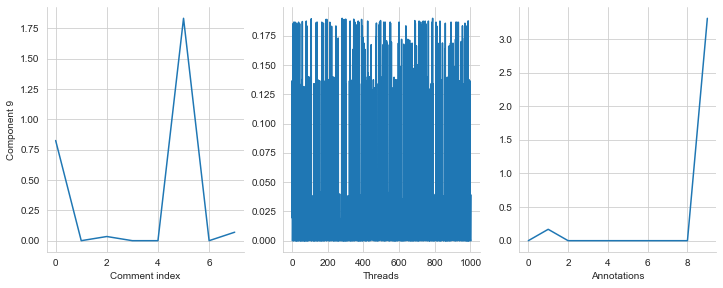

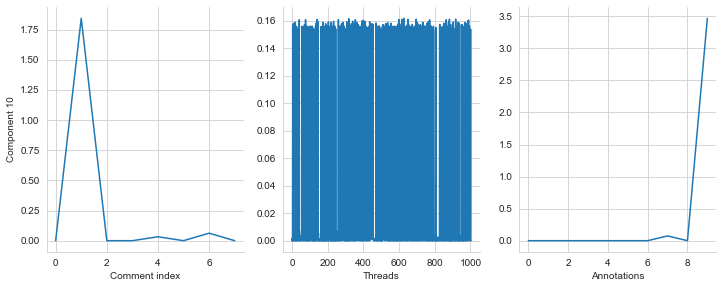

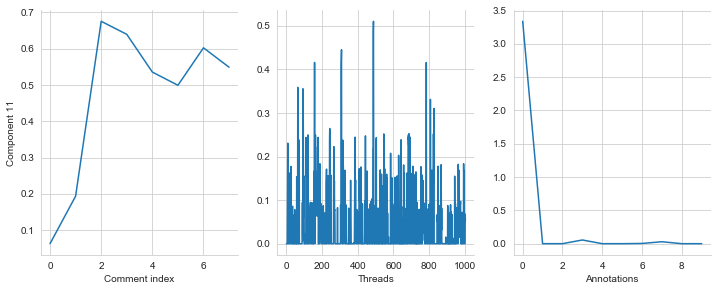

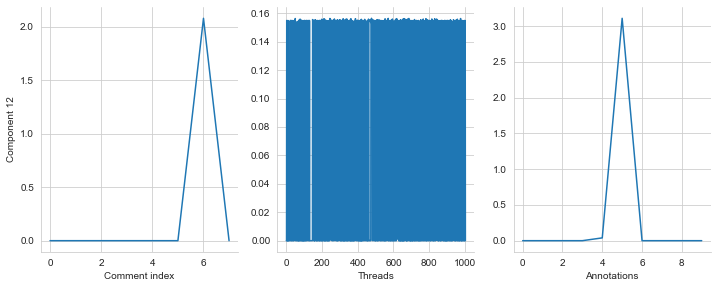

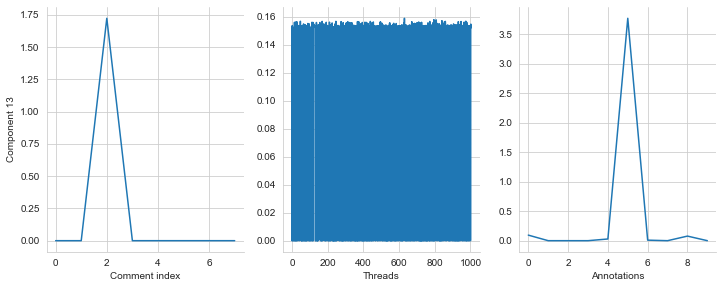

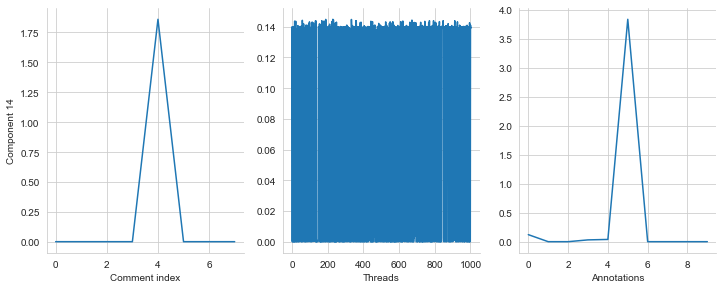

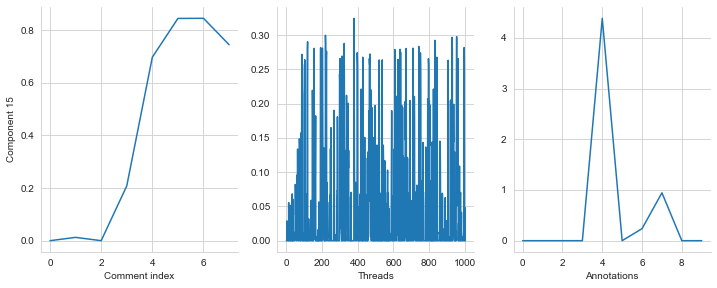

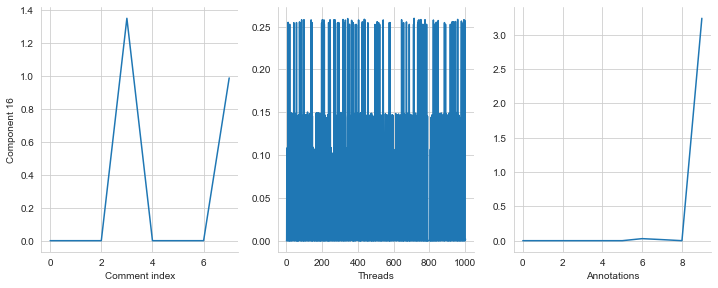

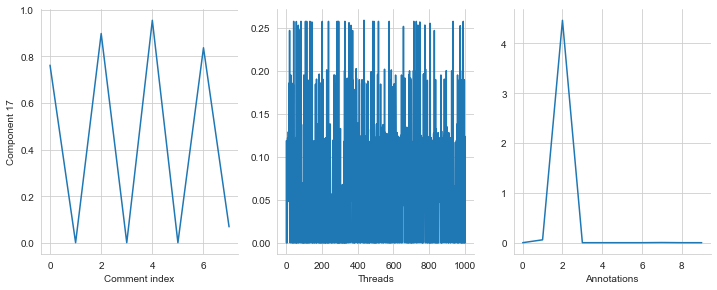

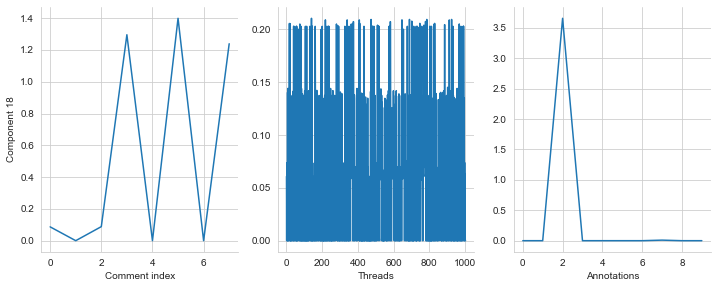

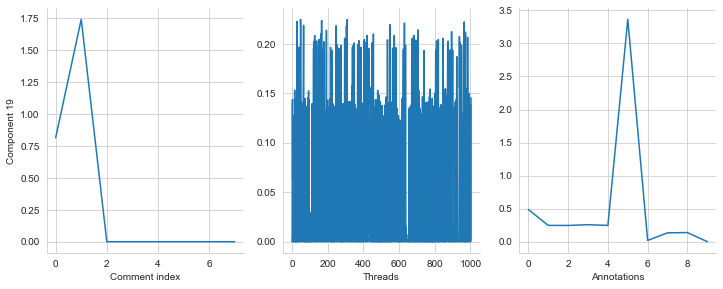

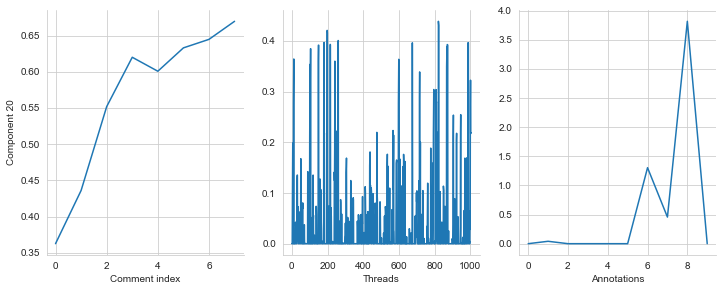

In [34]:
td.summarize(corpus, axis_names=['Comment index', 'Threads', 'Annotations'], 
             output_dir='convokit/tensor_decomposer/reports/coarse-discourse', 
             report_title='Coarse discourse', 
             liwc=True)

### Some breakdowns

For each component, how many threads are positive?

In [176]:
td.factors[1].T

array([[0.13681475, 0.        , 0.01582937, ..., 0.        , 0.11984673,
        0.15773078],
       [0.14476641, 0.        , 0.0654573 , ..., 0.07647572, 0.00521839,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.08321622, 0.        ,
        0.        ],
       ...,
       [0.06084812, 0.        , 0.07367538, ..., 0.00250085, 0.        ,
        0.        ],
       [0.        , 0.00801732, 0.13665913, ..., 0.        , 0.00253881,
        0.14545348],
       [0.        , 0.        , 0.        , ..., 0.3224003 , 0.21721548,
        0.21893338]])

In [175]:
td.factors[1].shape

(1004, 20)

In [182]:
thread_df = pd.DataFrame(td.factors[1].T)

In [190]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()

def std_scale_df(df):
    d = dict()
    for i in range(df.shape[0]):
        d[i+1] = std_scaler.fit_transform(np.array(df.iloc[i]).reshape(-1, 1)).flatten()
    return pd.DataFrame.from_dict(d).T

In [192]:
def get_component_decomposition_nonnegative(V):
    feat_df = pd.DataFrame(V, index=list(range(1, V.shape[0]+1)), columns=list(range(1, V.shape[1]+1))).T
    retval = dict()
    for i in range(feat_df.shape[0]):
        s = sorted(list(feat_df.iloc[i].items()), key=lambda x: x[1], reverse=True)
        pos = [x[0] for x in s if x[1] >= 1]
        retval[i+1] = {'pos': pos}
    return retval

In [197]:
decomposed = get_component_decomposition_nonnegative(std_scale_df(thread_df).T)

In [203]:
print(decomposed[2]['pos'])

[510, 40, 75, 434, 287, 988, 575, 713, 483, 517, 282, 288, 515, 518, 758, 977, 81, 235, 290, 106, 237, 481, 727, 292, 577, 990, 57, 131, 327, 55, 372, 144, 194, 592, 736, 812, 992, 142, 830, 747, 32, 161, 509, 677, 100, 828, 370, 42, 607, 742, 566, 406, 698, 767, 133, 183, 24, 270, 482, 200, 97, 865, 20, 879, 775, 943, 799, 62, 265, 214, 919, 837, 644, 761, 533, 958, 364, 109, 778, 373, 401, 445, 512, 280, 421, 367, 523, 580, 884, 369, 350, 122, 963, 657, 789, 68, 933, 102, 455, 437, 816, 982, 160, 960, 205, 995, 772, 663, 349, 285, 979, 705, 310, 272, 733, 99, 186, 777, 69, 66, 646, 716, 968, 471, 17, 218, 931, 877, 363, 366, 490, 966, 779, 413, 702, 375, 354, 19, 377, 689, 582, 886, 925, 786, 393, 881, 695, 392, 134, 352, 913, 611, 423, 340, 408, 391, 681, 655, 549, 497, 283, 703, 817, 361]


In [273]:
for idx, utt in enumerate(corpus.iter_utterances(min_length)):
    if idx == 361:
        print(utt.id)
        break

t3_2sqie0


In [272]:
corpus.get_conversation('t3_2sqie0').print_conversation_structure(lambda utt: str(utt.meta['annotation-types']))

['question', 'question', 'question']
    ['answer', 'answer', 'answer']
        ['question', 'question', 'question']
            ['answer', 'answer', 'question']
                ['elaboration', 'elaboration', 'answer']
                    ['question', 'question', 'answer']
                        ['question', 'question', 'question']
                            ['answer', 'answer', 'answer']
                                ['elaboration', 'question', 'disagreement']
                                    ['elaboration', 'answer', 'elaboration']
                                        ['elaboration', 'question', 'elaboration']


In [267]:
td.factors[1][361]

array([0.        , 0.17409094, 0.        , 0.        , 0.        ,
       0.        , 0.13865875, 0.        , 0.14790202, 0.00098767,
       0.        , 0.        , 0.        , 0.13987859, 0.        ,
       0.14313724, 0.05297793, 0.19997529, 0.        , 0.        ])

In [270]:
np.array(std_scale_df(pd.DataFrame(td.factors[1]).T).T.iloc[361])

array([-0.53685394,  1.07220459, -0.59076194, -1.0061243 , -0.97047404,
       -0.99434718,  1.09429151, -0.51183815,  1.52251893, -0.59439209,
       -0.6436433 , -0.957773  , -0.95865437,  0.97304048, -0.63270343,
        0.95634251, -0.14713657,  2.11789678, -0.78076032, -0.46747878])

### TCA on Concat

In [79]:
concat_all = {}
for utt_idx, utt in enumerate(corpus.iter_utterances(selector=min_length)):
    concat = {}
    for idx in range(1, 8+1):
        for k, v in utt.meta['annot-dict-{}'.format(idx)].items():
            concat[k+str(idx)] = v
    concat_all[utt_idx] = concat

In [81]:
len(concat_all)

1004

In [84]:
# hack to make one convo hold the concatenated data
special_convo = corpus.random_conversation()

In [86]:
special_convo.meta['special'] = True
for k, v in concat_all.items():
    special_convo.meta['concat_{}'.format(k)] = v

In [94]:
td_concat = TensorDecomposer(feature_set=['concat_{}'.format(idx) for idx in range(1004)], 
                      obj_type="conversation", tensor_func='tensortools-ncp-bcd', rank=20)

In [95]:
td_concat.fit(corpus, selector=lambda convo: convo.meta.get('special', False) == True)

Constructing tensor...Done.
Decomposing tensor...NCP_BCD: iteration 1, objective 0.8442351272085952, improvement inf.
NCP_BCD: iteration 2, objective 0.8348241982472394, improvement 0.009410928961355758.
NCP_BCD: iteration 3, objective 0.830484404345673, improvement 0.004339793901566358.
NCP_BCD: iteration 4, objective 0.8234587378560183, improvement 0.007025666489654747.
NCP_BCD: iteration 5, objective 0.8095569873113578, improvement 0.013901750544660474.
NCP_BCD: iteration 6, objective 0.7842813999695187, improvement 0.0252755873418391.
NCP_BCD: iteration 7, objective 0.7518523425557275, improvement 0.03242905741379121.
NCP_BCD: iteration 8, objective 0.7214984916131199, improvement 0.030353850942607674.
NCP_BCD: iteration 9, objective 0.6970962063235837, improvement 0.02440228528953614.
NCP_BCD: iteration 10, objective 0.6784810921687402, improvement 0.018615114154843515.
NCP_BCD: iteration 11, objective 0.6643093877859564, improvement 0.014171704382783812.
NCP_BCD: iteration 12, ob

NCP_BCD: iteration 98, objective 0.5050403687197029, improvement 1.4257495305591839e-05.
NCP_BCD: iteration 99, objective 0.5050250764317784, improvement 1.5292287924517645e-05.
NCP_BCD: iteration 100, objective 0.5050082118550551, improvement 1.6864576723341074e-05.
NCP_BCD: iteration 101, objective 0.5049896061459644, improvement 1.8605709090624423e-05.
NCP_BCD: iteration 102, objective 0.5049687993163797, improvement 2.0806829584718578e-05.
NCP_BCD: iteration 103, objective 0.504945600714322, improvement 2.3198602057683537e-05.
NCP_BCD: iteration 104, objective 0.5049200010709497, improvement 2.5599643372342662e-05.
NCP_BCD: iteration 105, objective 0.5048921582494097, improvement 2.7842821540002838e-05.
NCP_BCD: iteration 106, objective 0.5048622837806518, improvement 2.987446875790667e-05.
NCP_BCD: iteration 107, objective 0.5048306577843193, improvement 3.1625996332440565e-05.
NCP_BCD: iteration 108, objective 0.5047976806482614, improvement 3.29771360579878e-05.
NCP_BCD: iterati

Directory already exists. Exiting summarize()


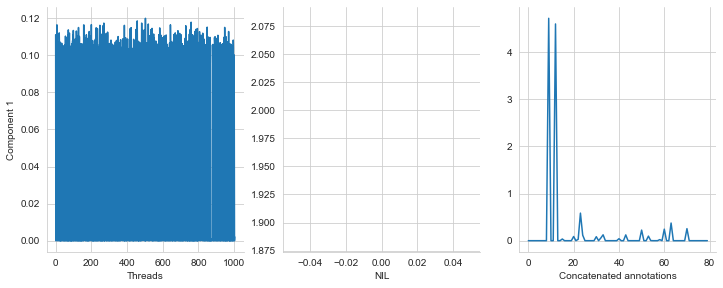

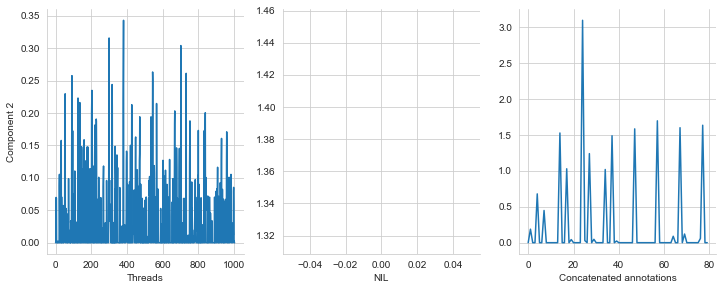

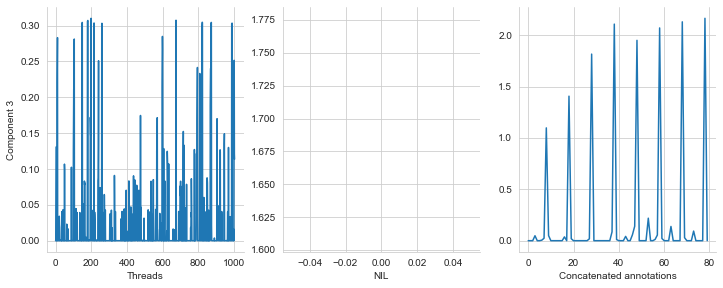

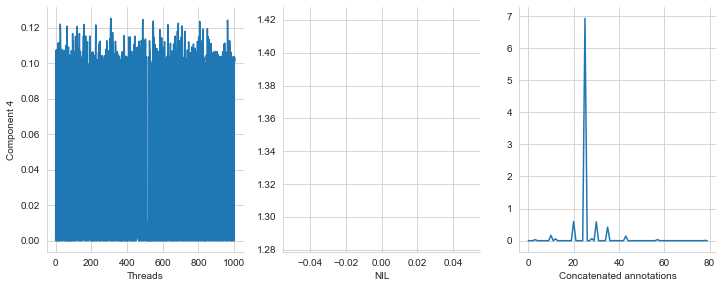

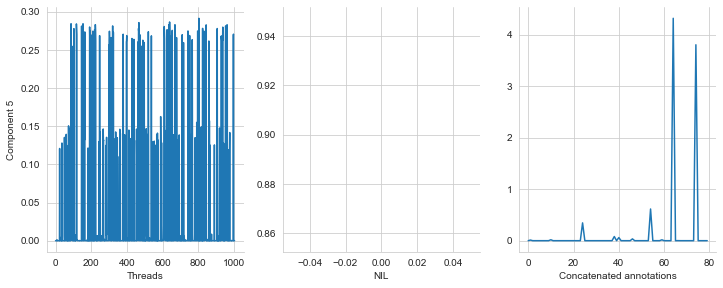

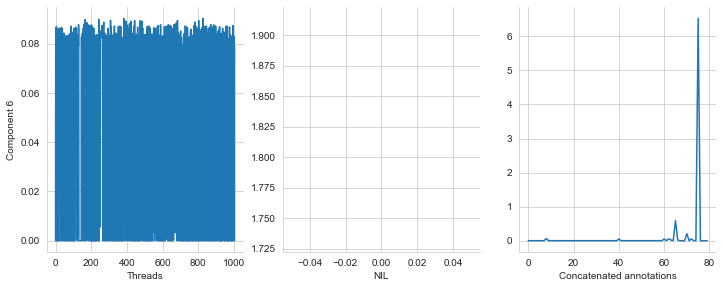

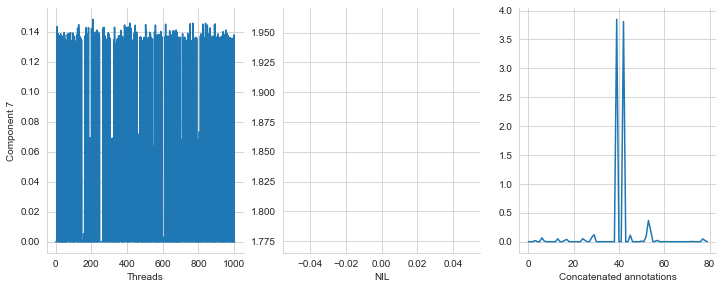

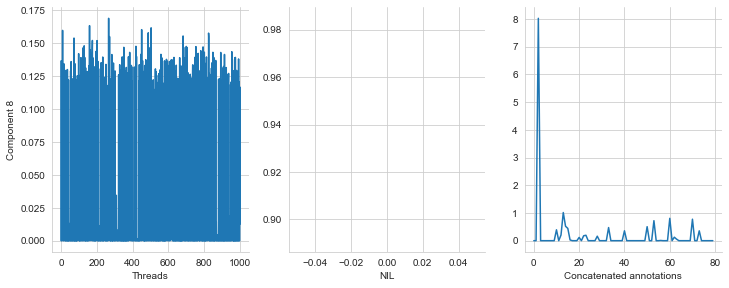

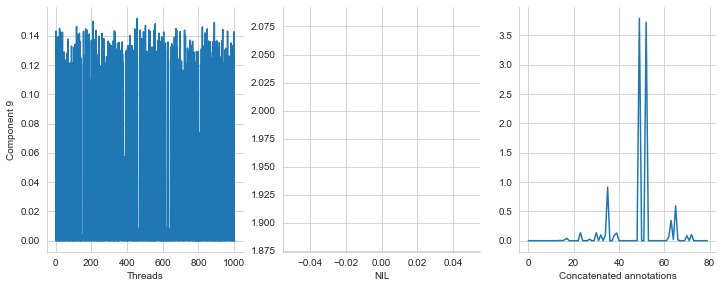

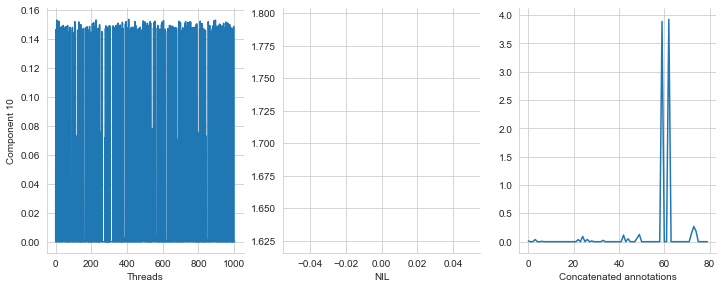

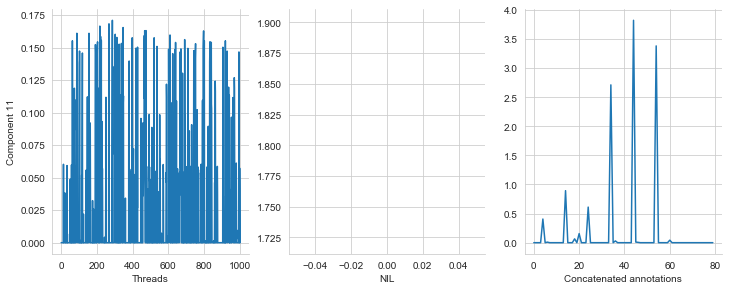

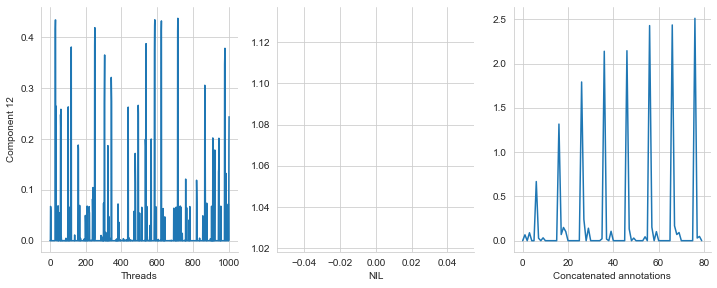

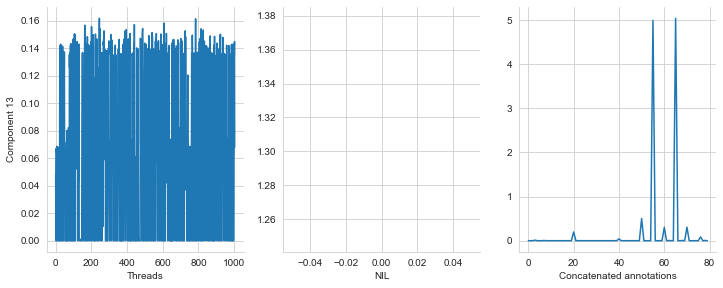

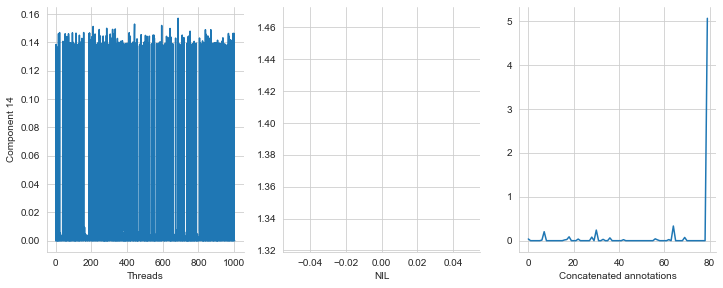

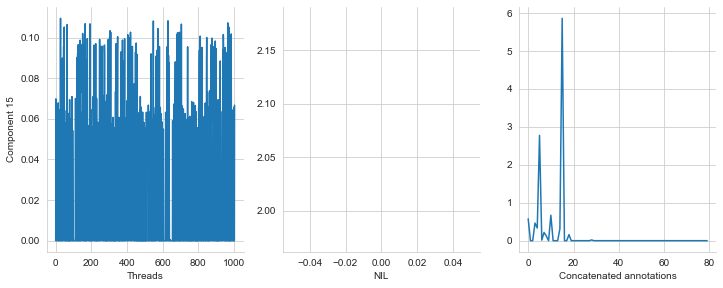

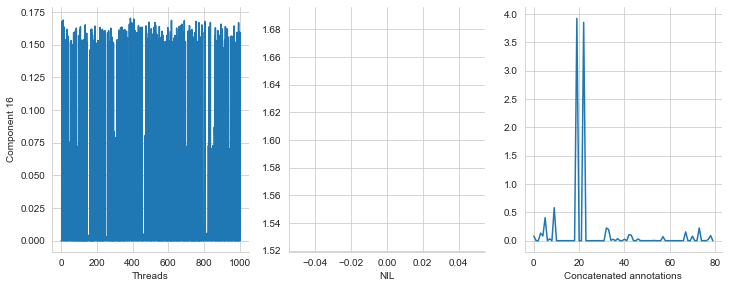

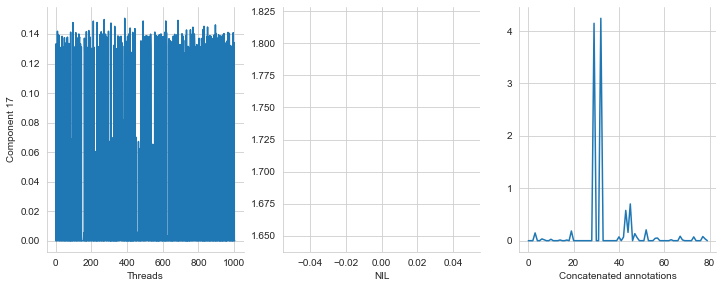

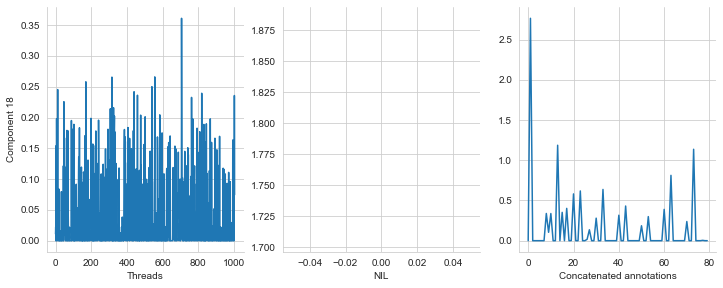

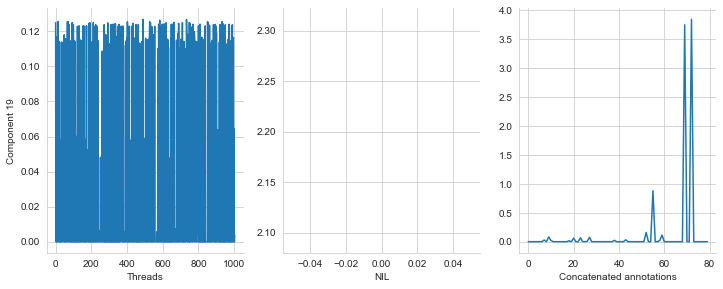

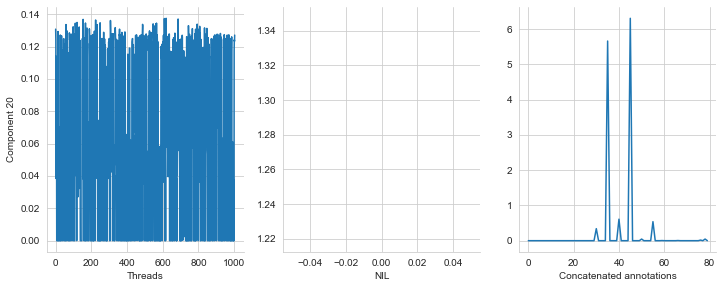

In [97]:
td_concat.summarize(corpus, axis_names=['Threads', 'NIL', 'Concatenated annotations'], 
             output_dir='convokit/tensor_decomposer/reports/coarse-discourse', 
             report_title='Coarse discourse', 
             liwc=True)

In [309]:
td_concat.factors[2].shape

(80, 20)

In [310]:
feat_df = pd.DataFrame(td_concat.factors[2].T)
std_scaled_df = std_scale_df(feat_df)

In [311]:
pd.set_option('display.max_columns', 500)
std_scaled_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79
1,-0.203022,-0.203022,-0.203022,-0.203022,-0.203022,-0.203022,-0.203022,-0.203022,-0.203022,6.278321,-0.203022,-0.203022,6.113959,-0.203022,-0.203022,-0.154138,-0.203022,-0.203022,-0.203022,-0.203022,-0.080979,-0.203022,-0.164243,0.600470,-0.042311,-0.203022,-0.203022,-0.203022,-0.203022,-0.203022,-0.086645,-0.203022,-0.124976,-0.031125,-0.203022,-0.203022,-0.203022,-0.203022,-0.203022,-0.203022,-0.145680,-0.203022,-0.203022,-0.034317,-0.203022,-0.203022,-0.203022,-0.203022,-0.203022,-0.203022,0.105646,-0.203022,-0.203022,-0.070327,-0.199131,-0.203022,-0.203022,-0.203022,-0.172059,-0.203022,0.132719,-0.203022,-0.203022,0.311387,-0.203022,-0.203022,-0.203022,-0.203022,-0.203022,-0.203022,0.147748,-0.203022,-0.203022,-0.203022,-0.203022,-0.203022,-0.203022,-0.203022,-0.203022,-0.203022
2,-0.392724,-0.057786,-0.392724,-0.392724,0.817046,-0.392724,-0.392724,0.405200,-0.392724,-0.392724,-0.392724,-0.392724,-0.392724,-0.392724,2.326552,-0.392724,-0.392724,1.439578,-0.392724,-0.315741,-0.392724,-0.392724,-0.392724,-0.392724,5.119913,-0.340829,-0.392245,1.815273,-0.392724,-0.309374,-0.392724,-0.392724,-0.392724,-0.392724,1.421666,-0.392724,-0.392724,2.258140,-0.392724,-0.351164,-0.392724,-0.392724,-0.392724,-0.392724,-0.392724,-0.392724,-0.392724,2.428777,-0.392724,-0.392724,-0.392724,-0.392724,-0.392724,-0.392724,-0.392724,-0.392724,-0.392724,2.628375,-0.392724,-0.392724,-0.392724,-0.392724,-0.392724,-0.392724,-0.233833,-0.392724,-0.392724,2.457905,-0.392724,-0.178203,-0.392724,-0.392724,-0.392724,-0.392724,-0.392724,-0.392724,-0.287360,2.518839,-0.392724,-0.392724
3,-0.352869,-0.352869,-0.352869,-0.267218,-0.352869,-0.352869,-0.344441,-0.310435,1.602558,-0.264853,-0.352869,-0.352869,-0.352869,-0.352869,-0.352869,-0.352869,-0.286676,-0.352869,2.152301,-0.319147,-0.352869,-0.352869,-0.352869,-0.352869,-0.352869,-0.352869,-0.352869,-0.320540,2.881642,-0.352869,-0.352869,-0.352869,-0.352869,-0.352869,-0.352869,-0.352869,-0.352869,-0.199979,3.401616,-0.333155,-0.352869,-0.352869,-0.352869,-0.278688,-0.352869,-0.352511,-0.250924,-0.102696,3.120390,-0.352869,-0.352869,-0.352869,-0.352869,0.037141,-0.352869,-0.352869,-0.331306,-0.254596,3.335242,-0.314542,-0.352869,-0.352869,-0.352869,-0.106250,-0.352869,-0.352869,-0.352869,-0.352869,3.441175,-0.300811,-0.352869,-0.352869,-0.352869,-0.186414,-0.352869,-0.352869,-0.352869,-0.352869,3.502304,-0.352869
4,-0.146109,-0.146109,-0.146109,-0.102496,-0.146109,-0.146109,-0.146109,-0.146109,-0.146109,-0.146109,0.068276,-0.146109,-0.073266,-0.146109,-0.146109,-0.146109,-0.146109,-0.146109,-0.146109,-0.146109,0.629791,-0.146109,-0.146109,-0.146109,-0.146109,8.805803,-0.146109,-0.146109,-0.062413,-0.146109,0.610844,-0.146109,-0.146109,-0.146109,-0.146109,0.401907,-0.146109,-0.146109,-0.142823,-0.146109,-0.146109,-0.146109,-0.146109,0.036727,-0.146109,-0.146109,-0.146109,-0.146109,-0.146109,-0.146109,-0.146109,-0.146109,-0.146109,-0.146109,-0.146109,-0.146109,-0.146109,-0.100611,-0.146109,-0.146109,-0.146109,-0.146109,-0.146109,-0.146109,-0.146109,-0.146109,-0.146109,-0.146109,-0.146109,-0.146109,-0.146109,-0.146109,-0.146109,-0.146109,-0.146109,-0.146109,-0.146109,-0.146109,-0.136304,-0.146109
5,-0.182390,-0.163734,-0.182390,-0.182390,-0.182390,-0.182390,-0.182390,-0.182390,-0.182390,-0.182390,-0.154781,-0.182390,-0.182390,-0.182390,-0.182390,-0.182390,-0.182390,-0.182390,-0.182390,-0.182390,-0.182390,-0.182390,-0.182390,-0.182390,0.359653,-0.182390,-0.182390,-0.182390,-0.182390,-0.182390,-0.182390,-0.182390,-0.182390,-0.182390,-0.182390,-0.182390,-0.182390,-0.182390,-0.055532,-0.182390,-0.088208,-0.182390,-0.182390,-0.182390,-0.182390,-0.182390,-0.127504,-0.182390,-0.182390,-0.182390,-0.182390,-0.182390,-0.182390,-0.182390,0.782582,-0.182390,-0.182390,-0.182390,-0.182390,-0.15

In [312]:
def get_component_decomposition_nonnegative(V):
    feat_df = pd.DataFrame(V, index=list(range(1, V.shape[0]+1)), columns=list(range(1, V.shape[1]+1))).T
    retval = dict()
    for i in range(feat_df.shape[0]):
        s = sorted(list(feat_df.iloc[i].items()), key=lambda x: x[1], reverse=True)
        pos = [x[0] for x in s if x[1] >= 1]
        retval[i+1] = {'pos': pos}
    return retval

In [313]:
decomposed = get_component_decomposition_nonnegative(std_scaled_df.T)

In [314]:
decomposed

{1: {'pos': [9, 12]},
 2: {'pos': [24, 57, 77, 67, 47, 14, 37, 27, 17, 34]},
 3: {'pos': [78, 68, 38, 58, 48, 28, 18, 8]},
 4: {'pos': [25]},
 5: {'pos': [64, 74]},
 6: {'pos': [75]},
 7: {'pos': [39, 42]},
 8: {'pos': [2]},
 9: {'pos': [49, 52, 35]},
 10: {'pos': [62, 59]},
 11: {'pos': [44, 54, 34, 14]},
 12: {'pos': [76, 66, 56, 46, 36, 26, 16]},
 13: {'pos': [65, 55]},
 14: {'pos': [79]},
 15: {'pos': [15, 5]},
 16: {'pos': [19, 22]},
 17: {'pos': [32, 29]},
 18: {'pos': [1, 13, 73, 63, 33, 23, 20]},
 19: {'pos': [72, 69, 55]},
 20: {'pos': [45, 35]}}

In [315]:
from collections import defaultdict
def index_to_semantic(ls):
    retval = defaultdict(list)
    for idx in ls:
        comment_idx = idx // 10 + 1
        retval[idx_to_annot[idx % 10]].append(comment_idx)
    for k, v in retval.items():
        retval[k] = sorted(v)
    return retval

In [316]:
for component_idx in range(1, V.shape[1]+1):
    print("Component index: {}\n".format(component_idx))
    print("Positive:")
    print(dict(index_to_semantic(decomposed[component_idx]['pos'])))
    print("------------------------------\n")

Component index: 1

Positive:
{'question': [1], 'answer': [2]}
------------------------------

Component index: 2

Positive:
{'disagreement': [2, 3, 4], 'negativereaction': [2, 3, 4, 5, 6, 7, 8]}
------------------------------

Component index: 3

Positive:
{'other': [1, 2, 3, 4, 5, 6, 7, 8]}
------------------------------

Component index: 4

Positive:
{'elaboration': [3]}
------------------------------

Component index: 5

Positive:
{'disagreement': [7, 8]}
------------------------------

Component index: 6

Positive:
{'elaboration': [8]}
------------------------------

Component index: 7

Positive:
{'question': [4], 'answer': [5]}
------------------------------

Component index: 8

Positive:
{'answer': [1]}
------------------------------

Component index: 9

Positive:
{'question': [5], 'answer': [6], 'elaboration': [4]}
------------------------------

Component index: 10

Positive:
{'answer': [7], 'question': [6]}
------------------------------

Component index: 11

Positive:
{'disa

KeyError: 21

### Concrete example

In [274]:
td_concat.factors[0][361]

array([0.10455042, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.13741621, 0.        , 0.04821191, 0.07028808,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.13812494, 0.        , 0.11618165, 0.04757957])

In [276]:
np.array(std_scale_df(pd.DataFrame(td_concat.factors[0]).T).T.iloc[361])

array([ 1.06215353, -0.57493456, -0.40608557, -0.9759444 , -0.54223179,
       -1.0133072 ,  1.77236991, -0.61991382,  0.19476288,  0.51042779,
       -0.57785507, -0.29534161, -1.10885148, -0.54736953, -0.75468941,
       -0.6364383 ,  1.69676309, -0.64161133,  1.70737488, -0.22939612])

## Comparison: An SVD analysis

In [282]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

In [155]:
for convo in corpus.iter_conversations():
    utts = convo.get_chronological_utterance_list()
    for utt_idx in range(len(utts) - LENGTH):
        subset = utts[utt_idx: utt_idx + LENGTH]
        start_utt = utts[utt_idx]
        for idx, utt in enumerate(subset):
            start_utt.meta['annot-dict-{}'.format(idx+1)] = utt.meta['annot-dict']
        start_utt.meta['valid'] = True

In [157]:
for convo in corpus.iter_conversations():
    utts = convo.get_chronological_utterance_list()
    for utt_idx in range(len(utts) - LENGTH):
        subset = utts[utt_idx: utt_idx + LENGTH]
        start_utt = utts[utt_idx]
        start_utt.meta['concat'] = dict()
        for idx, utt in enumerate(subset):
            d = start_utt.meta['annot-dict-{}'.format(idx+1)].copy()
            start_utt.meta['concat'].update({k+"_"+str(idx): v for k, v in d.items()})

In [283]:
concat_vals = []
for utt in corpus.iter_utterances(lambda u: u.meta['valid']):
    concat_vals.append(list(utt.meta['concat'].values()))

In [288]:
svd = TruncatedSVD(n_components=40, random_state=42)
svd.fit(concat_vals)

TruncatedSVD(algorithm='randomized', n_components=40, n_iter=5, random_state=42,
             tol=0.0)

In [317]:
U, s, V = svd.transform(concat_vals) / svd.singular_values_, \
        svd.singular_values_, \
        svd.components_.T

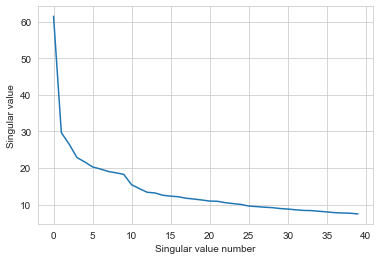

In [318]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(s)
plt.xlabel("Singular value number")
plt.ylabel("Singular value")
plt.show()

In [319]:
idx_to_annot = {idx: v for idx, v in enumerate(annotation_types)}

In [320]:
idx_to_annot

{0: 'agreement',
 1: 'announcement',
 2: 'answer',
 3: 'appreciation',
 4: 'disagreement',
 5: 'elaboration',
 6: 'humor',
 7: 'negativereaction',
 8: 'other',
 9: 'question'}

In [321]:
from collections import defaultdict
def index_to_semantic(ls):
    retval = defaultdict(list)
    for idx in ls:
        comment_idx = idx // 10 + 1
        retval[idx_to_annot[idx % 10]].append(comment_idx)
    for k, v in retval.items():
        retval[k] = sorted(v)
    return retval
        

In [322]:
feat_df = pd.DataFrame(V.T)
std_scaled_df = std_scale_df(feat_df)

In [323]:
def get_component_decomposition(V):
    feat_df = pd.DataFrame(V, index=list(range(1, V.shape[0]+1)), columns=list(range(1, V.shape[1]+1))).T
    retval = dict()
    for i in range(feat_df.shape[0]):
        s = sorted(list(feat_df.iloc[i].items()), key=lambda x: x[1], reverse=True)
        neg = [x[0] for x in s if x[1] <= -1]
        pos = [x[0] for x in s if x[1] >= 1]
        retval[i+1] = {'neg': neg, 'pos': pos}
    return retval

In [324]:
decomposed = get_component_decomposition(std_scaled_df.T)

In [325]:
for component_idx in range(1, V.shape[1]+1):
    print("Component index: {}\n".format(component_idx))
    print("Positive:")
    print(dict(index_to_semantic(decomposed[component_idx]['pos'])))
    print("Negative:")
    print(dict(index_to_semantic(decomposed[component_idx]['neg'])))
    print("------------------------------\n")

Component index: 1

Positive:
{'elaboration': [2, 3, 4, 5, 6, 7, 8], 'question': [1], 'answer': [2, 4]}
Negative:
{'announcement': [2, 3, 4, 5, 6, 7, 8]}
------------------------------

Component index: 2

Positive:
{'question': [1, 3, 5, 7], 'answer': [2, 4, 6, 8]}
Negative:
{'elaboration': [1, 2, 3, 4, 5, 6, 7, 8], 'answer': [1]}
------------------------------

Component index: 3

Positive:
{'answer': [1, 3, 5, 7], 'question': [2, 4, 6, 8]}
Negative:
{'elaboration': [2, 4, 5, 6, 7], 'disagreement': [4, 5, 6, 7]}
------------------------------

Component index: 4

Positive:
{'disagreement': [2, 3, 4, 5, 6, 7, 8], 'answer': [2], 'question': [1, 4]}
Negative:
{'other': [4, 5, 6, 7, 8], 'elaboration': [2, 4, 5, 6]}
------------------------------

Component index: 5

Positive:
{'answer': [1, 6, 8], 'question': [2, 3, 5, 7], 'elaboration': [1, 2], 'disagreement': [2]}
Negative:
{'question': [1, 6], 'elaboration': [3, 5, 6], 'answer': [2]}
------------------------------

Component index: 6


### Thread analysis

In [279]:
U[361]

array([ 0.03118551,  0.06101737,  0.02581589,  0.01150393,  0.00133164,
       -0.01662537,  0.02302951,  0.03275602,  0.03951006, -0.03215028,
       -0.01130107,  0.00887408, -0.00771207, -0.00881213, -0.02987345,
        0.01083359,  0.007435  ,  0.00325117,  0.00210878,  0.03701111])

In [280]:
np.array(std_scale_df(pd.DataFrame(U).T).T.iloc[361])

array([ 0.06919011,  1.90381455,  0.73616953,  0.35815065, -0.03936228,
       -0.50598373,  0.70398086,  1.04812002,  1.21190359, -1.0820618 ,
       -0.38142702,  0.26632237, -0.27861651, -0.32240117, -0.97797038,
        0.33379902,  0.22825614,  0.08154659,  0.06342371,  1.16473734])

### Sanity-checking

In [171]:
from collections import defaultdict
announcement_occurrences = defaultdict(int)
for convo in corpus.iter_conversations():
    for idx, utt in enumerate(convo.get_chronological_utterance_list()):
        if 'announcement' in utt.meta['annotation-types']:
            announcement_occurrences[idx] += 1
        

In [172]:
announcement_occurrences

defaultdict(int, {0: 2650, 1: 1})

In [249]:
from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix

In [250]:
u, s, v_trans = svds(csr_matrix(concat_vals).asfptype(), k=60)

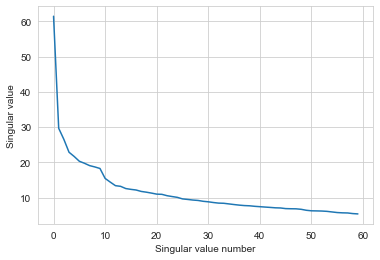

In [251]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(s[::-1])
plt.xlabel("Singular value number")
plt.ylabel("Singular value")
plt.show()

In [243]:
u.shape

(1004, 60)

In [244]:
s.shape

(60,)

In [245]:
v_trans.shape

(60, 80)

In [246]:
u

array([[-0.00110352, -0.00668104,  0.00164573, ...,  0.01989116,
         0.02542974, -0.02752928],
       [-0.00098165, -0.00898345,  0.01240117, ..., -0.01926245,
        -0.02806706, -0.02471965],
       [-0.00915241,  0.00019491, -0.02203128, ...,  0.01436155,
        -0.00897923, -0.02721618],
       ...,
       [-0.00669696,  0.02433432, -0.01303033, ..., -0.0091658 ,
        -0.03348582, -0.04291112],
       [-0.00467099,  0.12488992, -0.02763303, ...,  0.01448423,
        -0.0343585 , -0.02986293],
       [ 0.00443304, -0.06793185,  0.02715777, ...,  0.02028065,
        -0.03845976, -0.03115239]])

In [247]:
U

array([[ 2.75292773e-02,  2.54297411e-02, -1.98911850e-02, ...,
        -1.54563068e-02, -2.34415726e-04, -1.50669918e-03],
       [ 2.47196491e-02, -2.80670486e-02,  1.92624599e-02, ...,
        -2.92827855e-02,  2.94118307e-02, -2.71512326e-02],
       [ 2.72161823e-02, -8.97922960e-03, -1.43615604e-02, ...,
         3.35042503e-05, -1.91211887e-02, -1.04165175e-02],
       ...,
       [ 4.29111213e-02, -3.34858177e-02,  9.16577796e-03, ...,
        -7.64440128e-03,  2.13339981e-03, -1.45011072e-02],
       [ 2.98629278e-02, -3.43584895e-02, -1.44841532e-02, ...,
        -1.80858760e-02,  4.82471626e-02,  4.12981231e-02],
       [ 3.11523923e-02, -3.84597540e-02, -2.02807327e-02, ...,
        -4.89050331e-02, -4.09862134e-02,  2.53105595e-02]])

In [229]:
u.shape

(1004, 1004)

In [230]:
s.shape

(80,)

In [231]:
v_trans.shape

(80, 80)

In [42]:
concat_vals = np.array(concat_vals)

In [35]:
for convo in corpus.iter_conversations():
    
    convo.meta['concat'] = dict()
    for idx in range(1, 6+1):
        d = convo.meta['annot-dict-{}'.format(idx)].copy()
        convo.meta['concat'].update({k+"_"+str(idx): v for k, v in d.items()})

['agreement',
 'announcement',
 'answer',
 'appreciation',
 'disagreement',
 'elaboration',
 'humor',
 'negativereaction',
 'other',
 'question']

In [34]:
u, s, vh = np.linalg.svd(a, full_matrices=True)

TypeError: _svd_dispatcher() got an unexpected keyword argument 'n_components'

In [98]:
components = td.get_components(corpus, selector=lambda convo: convo.meta['longest_path'] >= 8)

In [96]:
td.thread_anomaly_threshold = 1.5

In [84]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)

In [94]:
td.get_component_example(components, 1)

,text,speaker,meta.question
id,,,
t3_4al3dc,"Hi, I'm a programmer by profession (C/C++) and I fancied taking a stab at the electronics part of things so I bought the ard hobo starter kit.\n\nThis was good to get started with arduino, but I felt it lacks explaining things. For example when I wire up an led it says I need a specific resistor. It doesn't ever seem to explain why I need that specific one or why one is needed at-all.\n\nIs there a better resource for this sort of detail? I'm also not interested in the programming side as I've got that covered already.",olig15,1
t1_d11i5sc,"Others here have recommended books. Get one of those, get a good handle on Ohm's law and the concepts of voltage, current, capacitance, and inductance, and then start looking at example circuits.\n\nIC vendors can be a good source of information. Any IC is likely to have at least one 'typical circuit' shown in the data sheet, and they often have app notes with more information. They don't always explain the *why* if it's considered obvious, but when the data sheet tells you the device needs decoupling capacitors located as close as possible to the supply pins, you can Google that and get all of the detail you need.\n\nI'm a full-time embedded systems developer and 90% of my hardware work is just gluing together components according to their data sheets and applying a handful of design guidelines. I don't think I've ever had to apply Kirchoff's circuit laws for anything more complicated than a voltage divider.\n\nAs for the programming side, this is probably a bad place for me to say this, but if you're an experienced C/C++ programmer I recommend getting off Arduino once you're comfortable with the basics if you're planning to do more than the occasional one-off project of less than a thousand lines of code.\n\n",madsci,0
t1_d11m103,Why do you say he should not stick with Arduino since he is a programmer?,hoti0101,1
t1_d11mkfc,"Because the Arduino framework is a ""dumbed down"" language designed for ""artists"" and ""creative"" people. It strips away the nuance and detailed control that makes programming an art and not a task of only cobbling together other people's libraries. Read the history of it's development.",drank_too_much,0
t1_d11mne4,Fair enough. What other tools or techniques are out there for building your own hardware?,hoti0101,1
t1_d11peo9,"I have professional experience so it makes it easy for me when searching for information, merely because I know what I am looking for. Using google is major. For instance, google ""microchip application notes"", find the listing of all the application notes here: http://www.microchip.com/wwwcategory/TaxonomySearch.aspx?show=Application%20Notes&ShowField=no and then go to town. I am happy no one suggested ""The Art of Electronics"" which I see as the most over hyped and over priced books in the field.\n\nClarification: A good reason to move away from Arduino is because it is a professional dead end.",drank_too_much,0
t1_d11qbx5,"what would you recommend as a next step, or crucial tools to learn? I'm studying Industrial Automation post grad but would like to move towards embedded design, PLCs just seem a bit simple so far..",4gnomen,1
t1_d11xc2j,"> next step\n\nProbably the simplest one is getting the AtmelStudio. It's free, it works with (almost) all Atmel MCs and you can just move easily from Arduino to, say, ATMega328, making the transition virtually painless.",jacekplacek,0


In [105]:
components[7]['pos_feats']

['answer']

In [103]:
td.get_component_example(components, 8)

,text,speaker,meta.answer
id,,,
t3_3y0m9v,,[deleted],0
t1_cy9jr5c,"Child labor didn't begin in the Industrial Revolution. Before children toiled in factories during the 19th and 20th centuries, they toiled on farms, which wasn't any better. A shortage of wealth causes child labor, not a lack of regulations. No parent wants to send their child to work in a dangerous place if they can help it. The accumulation of wealth from the Industrial Revolution finally gave parents the ability to start sending their children to schools instead of farms or factories.",Shiner_Black,1
t1_cy9nu3c,"That does not address the issue though. \n\nHow would a deregulated/unregulated capitalist-based market system avoid child labor? At this point, it's an inevitability as the working poor would be exponentially poorer, and thus all the more desperate; coupled with the higher demand for even cheaper goods... A truly ""laissez-faire capitalist"" society would be rife with child labor. \n\n*Most* consumers easily trade moral standards for cheaper/easier goods.",TheLateThagSimmons,0
t1_cy9oe1e,By making people wealthy enough that the children don't need to work. \n\nWhich is exactly what happened in the US and Europe. \n\nNot having children work to support the family is a luxury that parents will grab as soon as it is available to them.,[deleted],1
t1_cy9olr7,"How would the working poor make *more* money by reducing the minimum wage (possibly to zero)? Furthermore by reducing the ability to stay afloat sans working (welfare/unemployment) would flood the labor market with unskilled (even skilled) labor, further driving down wages. \n\nI know you'll point to countries with no minimum wage and ignore the fact that they have a much stronger (and larger) public sector as well as very strong unionization and very strict borders or immigration.",TheLateThagSimmons,0
t1_cy9pr9v,"The US started banning child labor about 80 years before passing minimum wage laws. \n\nChild labor is made unnecessary by raising wealth levels in society. \n\nWhich is what actually happened in real life over the 19th century in the US. \n\nSo yes, I'll point to a country where it happened without a minimum wage: The United States in the 19th century. \n\nUnions can certainly play a part in raising more immediate wealth distribution (and I have no issue with private sector unions) \n\nBut unless you raise the average wealth level of the society, none of that matters as the wealth isn't there to be distributed. \n",[deleted],1
t1_cy9pxx8,"Right, you did not address the issue *at all*. If anything, you proved my point.\n\nThe US had child labor all the way up until they had to *ban it*. \n\n---\n\nWe need to back up and address the situation as presented. How would a laissez-faire capitalist system be devoid of child labor? How would eliminating the minimum wage and welfare programs *help* the working poor in a laissez-faire capitalist society? \n\nNot... Was it worse before in the United States?",TheLateThagSimmons,0
t1_cy9rzf4,The welfare state and minimum wage laws both harm the poor. The former distorts the incentives to work and creates inter-generational poverty. The latter make it illegal to hire someone who's productivity is below the minimum wage value. This prevents unskilled workers from gaining the job experience necessary to increase what they can offer and obtain better positions in the future. It also incentives employers to replace their unskilled workers with skilled ones or machines.,Shiner_Black,1


In [109]:
td.get_component_example(components, 7)

,text,speaker,meta.announcement
id,,,
t3_29dtve,I am hooked on crochet.\n\nTeehee.,jenbenfoo,1
t1_cik0gm8,Sometimes i dream about it :/ \n\ni would say i have a complete addiction/obsession going.,Q-Kat,0
t1_cik6gfe,I thought I was the only one.,peepeemccrappy,0
t1_cik6ri4,we should start a support group :D if i'm not looking at patterns online i'm browsing the Russian crochet blogs and looking at buying yarn. now i'm even signed up to start teaching crochet in September XD \n\nI understand this is what it feels like to know what you want to do with your life which I've never had before.,Q-Kat,0
t1_cik9qga,Neither have I! Crochet has become my therapy for anxiety.,peepeemccrappy,0
t1_cikc9r6,mine too! I have panic disorder...,zeprocker022,0
t1_cikdc9o,Yay anxiety frenz!,peepeemccrappy,0
t1_cikdeqk,(My husbeast has GAD and panic disorder. I have bipolar and serious social anxiety),peepeemccrappy,0


In [114]:
corpus.get_conversation('t3_29dtve').get_utterances_dataframe()[['text', 'speaker', 'meta.majority_type']]

,text,speaker,meta.majority_type
id,,,
t3_29dtve,I am hooked on crochet.\n\nTeehee.,jenbenfoo,announcement
t1_cik0gm8,Sometimes i dream about it :/ \n\ni would say i have a complete addiction/obsession going.,Q-Kat,agreement
t1_cik6gfe,I thought I was the only one.,peepeemccrappy,None
t1_cik6ri4,we should start a support group :D if i'm not looking at patterns online i'm browsing the Russian crochet blogs and looking at buying yarn. now i'm even signed up to start teaching crochet in September XD \n\nI understand this is what it feels like to know what you want to do with your life which I've never had before.,Q-Kat,elaboration
t1_cik9qga,Neither have I! Crochet has become my therapy for anxiety.,peepeemccrappy,None
t1_cikc9r6,mine too! I have panic disorder...,zeprocker022,agreement
t1_cikdc9o,Yay anxiety frenz!,peepeemccrappy,appreciation
t1_cikdeqk,(My husbeast has GAD and panic disorder. I have bipolar and serious social anxiety),peepeemccrappy,None


In [118]:
td.get_component_example(components, 3)

,text,speaker,meta.elaboration
id,,,
t3_4eza74,"Here are the notable changes after tracking the most recent city captures:\n\n**BLOODTHIRST**\n\n* After the bombing raid of Mali, the Buccaneers **(82.94MM)** surpass the Inuit **(73.9MM)** for second-most civilian kills.\n* Vietnam **(52.58MM)** surpasses both the Maori **(47.9MM)** and Sibir **(41.56MM)** for fourth-most.\n* Morocco **(11.24MM)** jumps from 24th to 19th.\n* Sri Lanka **(5.28MM)** jumps from 28th to 22nd.\n\n-----\n\n**BLOODNOSE**\n\n* Mali **(32.8MM)** skyrockets from 59th place to fifth-most civilian deaths.\n* Afghanistan **(17.24MM)** jumps from 37th to 14th.\n* Carthage **(13.57MM)** jumps from 36th to 24th.\n* Sri Lanka **(1.67MM)** rises from 60th to 50th.\n\n-----\n\n**WAR GROWTH**\n\n* After claiming four free cities from Mali, the Buccaneers **(+134K)** become one of the select few to have positive growth, rising from 19th to 8th place.\n* Mali **(-37.6MM)** plummets from 9th to 58th.\n* Afghanistan **(-17.17MM)** drops from 25th to 46th.\n* Carthage **(-15.07MM)** drops from 27th to 44th.\n* Sri Lanka **(-1.16MM)** dips from 8th to 15th.\n\n-----\n\n**WORLDWIDE BLOODSHED**\n\n* There were **47.512MM** deaths in Part 50, making it the third-bloodiest installment yet, and **16.225MM** deaths in Part 51.\n* There were **16** and **17** city captures (respectively) in Parts 50 and 51.\n* Nuclear blasts killed **22.02MM** citizens in Part 50, and **1.58MM** in Part 51. The total number of nuclear deaths is now **63MM**, accounting for **8.14%** of all civilian casualties.\n\n* The total number of city captures is now **1582**.\n\n-----\n\n**The Battle Royale has claimed a grand total of *774,290,000* civilian lives.**",bluesox,0
t1_d24mli3,"The Death toll is more than the population of Europe, or the Population of North America, and more that twice the Population of the US, and more that 33 times the population of Australia, and about One Tenth of the Current World Population.",Lordfowl,1
t1_d24xu13,"To be completely honest, I'm startled that the death count isn't higher.",[deleted],1
t1_d24yljg,"We're only just witnessing conflicts akin to WW2. Also I don't think bombers kill civilians, so war doesn't hurt non combatants quite as frequently or potently.",[deleted],1
t1_d24zk7m,"True, it would be nice if we could figure out a way to factor bombers into the statistics.",[deleted],0
t1_d2504o1,"I just think of it as though bombers target strategic buildings, military camps and supply routes.",bluesox,1
t1_d25aym3,"If we were that humane a people, there would still be a Philippines...",ZanthorTitanius,0
t1_d25eqh4,This! ^,[deleted],0


In [119]:
td.get_component_example(components, 2)

text  \
id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [131]:
corpus.get_utterance('t1_d15lqk1').meta

{'post_depth': 5,
 'majority_type': 'appreciation',
 'majority_link': 't1_d15e1od',
 'annotation-types': ['appreciation', 'appreciation', 'appreciation'],
 'annotation-links': ['t1_d15e1od', 't1_d15e1od', 't1_d15e1od'],
 'ups': 1,
 'annot-dict': {'agreement': 0,
  'announcement': 0,
  'answer': 0,
  'appreciation': 1,
  'disagreement': 0,
  'elaboration': 0,
  'humor': 0,
  'negativereaction': 0,
  'other': 0,
  'question': 0},
 'appreciation': 1,
 'agreement': 0,
 'announcement': 0,
 'answer': 0,
 'disagreement': 0,
 'elaboration': 0,
 'humor': 0,
 'negativereaction': 0,
 'other': 0,
 'question': 0}

In [129]:
td.get_component_example(components, 4)

,text,speaker,meta.elaboration
id,,,
t3_4axsqa,"What could my shit be cut with that would make it hurt when I shoot up? It feels like I'm missing, but I'm not. My bf feels the same pain. It's great dope though, 7.5/10. I'm just freaked out about why it hurts.. any ideas?",LifeOnThePharm,0
t1_d154lhb,It's not like a histamine reaction?,7hr0wi74w4y,0
t1_d154o5e,"Nah. Im mildly allergic to morphine (bad hives, bad itching etc). So I get a reaction after every shot and it's nothing like that. I feel it burn all the way up my arm through my vein",LifeOnThePharm,0
t1_d1556fr,Is it bth? Or ecp?,7hr0wi74w4y,0
t1_d15e1od,Ecp but its cool. He replaced it with another g of better shit because I bitched about it so much and I've never bitched about his dope before.,LifeOnThePharm,0
t1_d15lqk1,Hell yea that's an awesome dboy,7hr0wi74w4y,0
t1_d15wcpa,"Yeah he is the best. Always has great shit (even the painful shit was good!), stays up late to serve me because I'm a server and work late hours, cheap and he isn't a user so its always on point or over .",LifeOnThePharm,1
t1_d15wuo0,"Lucky my dude acts like it's a cubicle job. Is only available 9 or 10 to like 5 on weekdays and like 8 on Friday and Saturday. You would think he's missing out on lot of business, but he says he doesn't deal with anything small. Has to be a gram or more.",7hr0wi74w4y,1


In [134]:
td.get_component_example(components, 9)

,text,speaker,meta.disagreement
id,,,
t3_x4tgk,First and foremost I want to make absolutely clear that I am not bashing Christians or belittling what happened at all.\n\nIt was just a thought that came to me. I have seen a lot of posts about asking God's blessing on the families of the people who were shot. In my mind it isnt clear why you would ask someone to bless a family member after that person has allowed the shooting to even occur.\n\nCan anyone make sense of that?,Tthrond76,0
t1_c5j5t6r,"Christianity isn't a religion that says god is going to come down and fix all of humanity's problems. In theory, that's up to us. God gave us the tools to be good people. If we choose to be disgusting assholes it's nobody's fault but our own.",[deleted],0
t1_c5j6h69,"Well technically if it's an all-powerful, all-knowing being that purposefully created the universe exactly as it is, then that would translate to him making every single person specifically to do everything they are ever going to do.\n\nMeaning he specifically made the twisted fuck who shot up the theater *with the intention of him doing exactly that*. I don't understand how they always seem to have such a shameful ignorance of cause and effect.",aflarge,1
t1_c5j6jbr,">Well technically if it's an all-powerful, all-knowing being that purposefully created the universe exactly as it is, then that would translate to him making every single person specifically to do everything they are ever going to do.\n\nJust because you made a clock doesn't mean you always know what time it is. \n\nIn christian theology anyway, god gives us the freedom to determine our own destiny. \n\nI think the problem here is that our conception of god is so muddled and vague we'll never get a clear answer out of this.",[deleted],1
t1_c5j6kjb,"If you made a clock and were all-knowing, you most certainly would always know what time it was.",aflarge,1
t1_c5j6ltk,You forgot the second part of that post. \n\nHow exactly do you know that the version of god you are talking about is *the* version of god? You don't. Neither do I. \n\n,[deleted],1
t1_c5j6n68,"You were talking about christianity, so I assumed that it would imply an all-powerful, all-knowing, perfect and deliberate creator of everything.",aflarge,1
t1_c5j6nti,"You know not even christians know exactly what god is, right?",[deleted],1


In [136]:
corpus.get_utterance('t1_c5j5t6r').meta['majority_type']

'answer'

In [137]:
td.get_component_example(components, 9)

,text,speaker,meta.disagreement
id,,,
t3_10xrqu,"It was mentioned multiple times that there is no returning in time to 19XX New York because of the time fractures (not the correct phrase, but I forget the exact one). Why don't Amy and Rory, back in time, *go somewhere else*? E.g., hop on a train to Los Angeles? Hop on a boat to Australia? They can't travel in *time* from that New York, but they can travel in *space* to somewhere that isn't a time-hotzone. \n\nCan Melody/River still go see them, since she said the vortex teleporter could get into the hotzone much easier than a tardis.\n\nAlso, there were a number of scenes in this episode where the weeping angels were approaching from opposing directions (e.g., from both ends of a hallway towards the person in the middle). How is that possible? If they're facing each other, they're observing each other, and shouldn't be able to move! The previous doctor used this trick to trap four angels when they surrounded the tardis, and he disappeared, leaving them facing each other.",burtonmkz,0
t1_c6hjgqv,"that was not the season finale. also, give it up. amy and rory are not coming back, because the only characters to come back have been captain jack, who wasn't really a companion, and sarah jane, who came for one episode and was ditched again.",[deleted],0
t1_c6hjqx8,Jack was a companion briefly.,ProtoKun7,1
t1_c6ho5c4,keyword BRIEFLY. Jack is independent of the doctor.,[deleted],0
t1_c6hpyyo,"But still qualifies as a companion. Adam was a companion and didn't make it past one trip, but it still counts. Jack lost his ship and travelled in the TARDIS, only regaining independence after being abandoned on the Game Station and leaving via his vortex manipulator. You suggested he never was a companion in a real sense.",ProtoKun7,1
t1_c6htlem,"jack is not a formal companion because he only hitch hikes, like river.",[deleted],1
t1_c6hy6xo,"But he was a formal full time companion at one point. *The Doctor Dances* to *The Parting of the Ways*. He didn't hitchhike then, that was full time, unlike River.",ProtoKun7,1
t1_c6i0m31,but he left on his own. he came on his won and left of his own accord.,[deleted],1


In [140]:
corpus.get_utterance('t1_c6hjgqv').meta

{'post_depth': 1,
 'majority_type': None,
 'majority_link': 't3_10xrqu',
 'annotation-types': ['answer', 'other'],
 'annotation-links': ['t3_10xrqu', 't3_10xrqu'],
 'ups': None,
 'annot-dict': {'agreement': 0,
  'announcement': 0,
  'answer': 1,
  'appreciation': 0,
  'disagreement': 0,
  'elaboration': 0,
  'humor': 0,
  'negativereaction': 0,
  'other': 1,
  'question': 0},
 'answer': 1,
 'other': 1,
 'agreement': 0,
 'announcement': 0,
 'appreciation': 0,
 'disagreement': 0,
 'elaboration': 0,
 'humor': 0,
 'negativereaction': 0,
 'question': 0}

In [143]:
td.get_component_example(components, 9)

,text,speaker,meta.disagreement
id,,,
t3_493d2b,Hello - I have a friend that insists that a hero that is most often firstpicked will have a lower winrate than a hero that is most often last picked (assuming a huge amount of games etc). \nCan anyone ELI5 why that is or why it's not like that ?,[deleted],0
t1_d0opuvk,"He's saying that because he's supposing the last pick will be a surprise pick that is not countered by the enemy\n\nThis is true sometimes, but only sometimes",teerre,0
t1_d0oq782,I made a reply to another post. Please take a look and see if you can find another way to see it that I'm not considering,[deleted],0
t1_d0oqbgo,"You're comparing the wrong thing, you need compare hero X being first picked with same hero X being last picked in multiple games. Of course in one game the last and first pick will have the same winrate \n",teerre,1
t1_d0oqny9,"with a hero pool of 2 on each faction: \nr1a + r5b vs d1x + d5y \nr1a + r5b vs d1y + d5x \nr1b + r5a vs d1y + d5x \nr1b + r5a vs d1x + d5y \nIf hero a wins on fp all the time both hero x AND hero y will suffer. Every time hero a wins twice on fp, hero x and y will lose once each. 2-2 score. 50% for FP. \nThe same is true for hero b etc. If a hero has 80% winrate on fp another or several other heroes will suffer low winrate on fp on the opposite team. \n1 hero, 2 heroes or 100 heroes. It's the same principle.",[deleted],0
t1_d0orizo,"Dude, you're making this much more complicated than it needs to be\n\nIt's really simple: \n\nFirst pick broodmother the winrate is shit, because it's easy to counter, last pick broodmother has a much better winrate, because when she's not countered she's much better \n\nThat's it",teerre,1
t1_d0osec4,"No because if you first pick broodmother and lose, you will pick another hero last pick instead that will lose aswell \nIncluding the enemy first pick and last pick that in turn will both win. \nYou are ignoring the rest of the heroes and tunnel visioning on brood only. \nWhenever fp brood loses, another last pick loses and enemy random fp+lastpick wins.\n",[deleted],1
t1_d0ost37,"Dude, your logic makes no sense\n\nYou're thinking in the same game, that makes no sense, you need think about different games\n\nYou need to think about first in one game and last pick in a different game",teerre,1


In [142]:
corpus.get_utterance('t1_d2o7juz').meta

{'post_depth': 7,
 'majority_type': 'answer',
 'majority_link': 't1_d2o7ema',
 'annotation-types': ['agreement', 'answer', 'answer'],
 'annotation-links': ['t1_d2o7ema', 't1_d2o7ema', 't1_d2o7ema'],
 'ups': 1,
 'annot-dict': {'agreement': 1,
  'announcement': 0,
  'answer': 1,
  'appreciation': 0,
  'disagreement': 0,
  'elaboration': 0,
  'humor': 0,
  'negativereaction': 0,
  'other': 0,
  'question': 0},
 'agreement': 1,
 'answer': 1,
 'announcement': 0,
 'appreciation': 0,
 'disagreement': 0,
 'elaboration': 0,
 'humor': 0,
 'negativereaction': 0,
 'other': 0,
 'question': 0}

In [148]:
from collections import Counter

In [1]:
dis_8 = 0
for convo_id in convo_df[convo_df['meta.longest_path'] >= 11].index:
    convo = corpus.get_conversation(convo_id)
    if convo.get_chronological_utterance_list()[9].meta['disagreement'] == 1:
        dis_8 += 1

NameError: name 'convo_df' is not defined

In [171]:
dis_8

33

In [160]:
annotation_types

['agreement',
 'announcement',
 'answer',
 'appreciation',
 'disagreement',
 'elaboration',
 'humor',
 'negativereaction',
 'other',
 'question']